##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

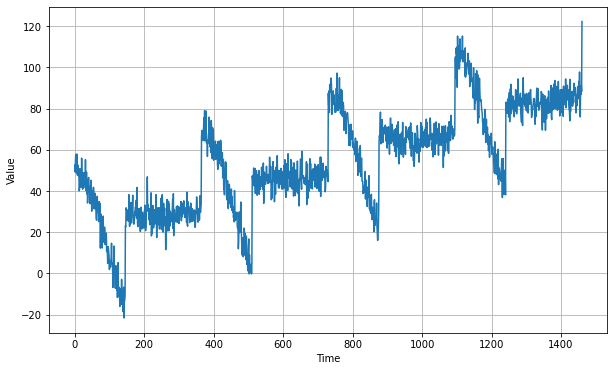

In [4]:
period = 365
time = np.arange(4 * period + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [8]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
split_time = 1000
time_train, time_valid = time[:split_time], time[split_time:]
x_train, x_valid = series[:split_time], series[split_time:]

### Linear Model

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

# Prepare datasets
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

# Train the model 
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 3s 13ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - l

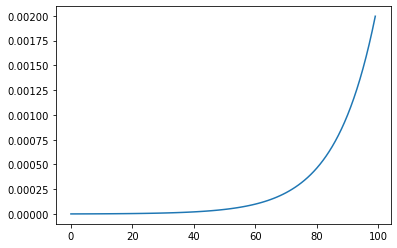

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

lr_schedule = lambda x: 1e-6 * 10**(x / 30)
value = []
for epoch in range(100):
    value.append(lr_schedule(epoch))
plt.plot(range(100), value)
plt.show()

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 67.6867 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 52.3572 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 17.6521 - mae: 18.1484 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4604 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9201 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8785 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8191 - mae: 8.3014 - lr: 1.84

In [ ]:
##### plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=0.8e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 52.0030 - mae: 52.5022 - val_loss: 11.1377 - val_mae: 11.6323
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 12.8904 - mae: 13.3822 - val_loss: 9.9080 - val_mae: 10.3953
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 10.1390 - mae: 10.6226 - val_loss: 9.4071 - val_mae: 9.8913
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 9.8998 - mae: 10.3874 - val_loss: 9.1787 - val_mae: 9.6672
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 9.7945 - mae: 10.2842 - val_loss: 9.0158 - val_mae: 9.5035
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 9.6740 - mae: 10.1591 - val_loss: 9.2011 - val_mae: 9.6852
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 9.6538 - mae: 10.1377 - val_loss: 8.8514 - val_mae: 9.3387
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - lo

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [15]:
lin_forecast.shape

(461,)

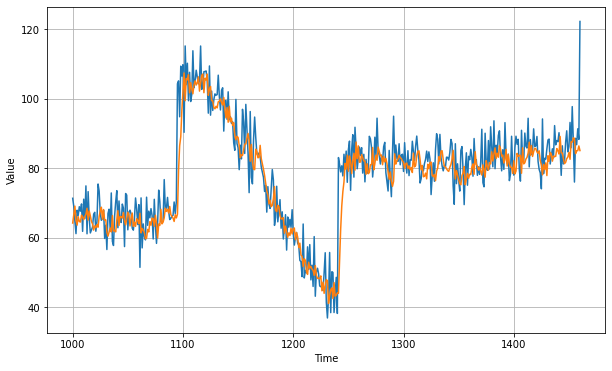

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.0008025

### Dense Model Forecasting

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(100, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(100, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 43.7560 - mae: 44.2552 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 42.3443 - mae: 42.8425 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 40.6206 - mae: 41.1179 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 38.6897 - mae: 39.1883 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 36.5315 - mae: 37.0301 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 34.1096 - mae: 34.6091 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 31.3998 - mae: 31.8987 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 28.3664 - mae: 28.8626 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 25.0367 - mae: 25.5345 

(1e-07, 0.005, 0.0, 30.0)

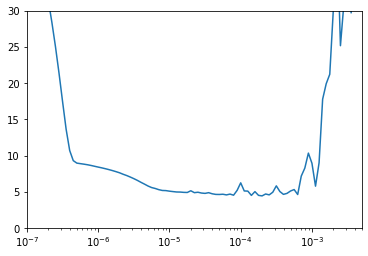

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(200, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(200, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/home/ubuntu/anaconda3/envs/tensorflow2.7_p38/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
31/31 [==============================] - 1s 21ms/step - loss: 22.5606 - mae: 23.0542 - val_loss: 13.6352 - val_mae: 14.1320
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 7.5533 - mae: 8.0351 - val_loss: 6.6161 - val_mae: 7.1029
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 6.5266 - mae: 7.0057 - val_loss: 5.7163 - val_mae: 6.1935
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 6.1137 - mae: 6.5947 - val_loss: 5.8605 - val_mae: 6.3472
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 5.8656 - mae: 6.3447 - val_loss: 5.8406 - val_mae: 6.3182
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 5.7037 - mae: 6.1812 - val_loss: 5.1699 - val_mae: 5.6444
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 5.6307 - mae: 6.1084 - val_loss: 5.1452 - val_mae: 5.6228
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 5.512

In [44]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

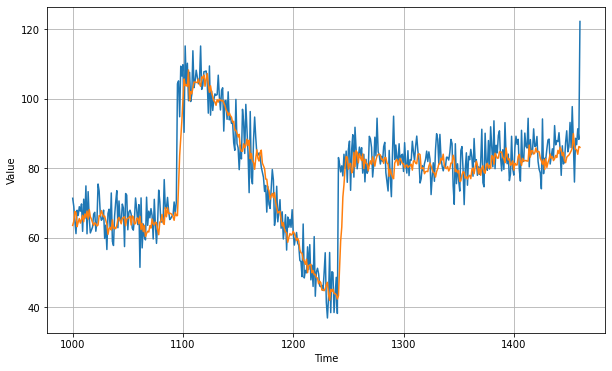

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [46]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

4.9125676